In [1]:
! pip install sentencepiece wget datasets torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.

In [2]:
import torch
import torch.nn as nn, torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset as Dset
from PIL import Image
import cv2, skimage.io as io 
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os, json, time, copy
import sentencepiece as spm
from sentencepiece import SentencePieceTrainer
from tqdm import tqdm, trange
from torchmetrics import Dice
import math, random
from typing import Any, Dict
import functools
from torch.cuda.amp import autocast, GradScaler

In [96]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [97]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_seed(42)

In [98]:
# Define the hyperparameters
batch_size = 8
learning_rate = 0.0001
embedding_size = 256
hidden_size = 256
n_heads = 8
n_layers = 6
dropout_prob = 0.1
max_sequence_length = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [99]:
# Define a transform to pre-process the training images.
transform = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from random location
    #transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

In [7]:
from google.colab import drive 
#drive.flush_and_unmount()
#drive.mount('/content/drive')

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [8]:
!pwd

/content


In [100]:
array_cap = []
with open('/content/drive/MyDrive/COCO_30000_captions.txt', 'r') as f_cap:
      for line in f_cap:
          array_cap.append(line.strip('\n').split(sep = '.')[0].lower())
          # if len(array_cap) == 10000:
          #   break

array_cap[:4]

['000000322141:a room with blue walls and a white sink and door',
 '000000016977:a car that seems to be parked illegally behind a legally parked car',
 '000000301837:a long empty, minimal modern skylit home kitchen',
 '000000315702:a bathroom sink with toiletries on the counter']

In [101]:
dict_cap = {}
for x in array_cap:
  k, v = x.split(sep = ':', maxsplit = 1)
  dict_cap[k] = v
  

# #dict_cap

In [102]:
len(dict_cap)

30000

In [103]:
data = {}
path = '/content/drive/MyDrive/COCO_subset_30000_train2017/'

for file in tqdm(os.listdir(path)):
  fname = file.split(sep = '.', maxsplit = 1)[0]

  if fname in dict_cap.keys():
    data[path + file] = dict_cap[fname]

100%|██████████| 30000/30000 [00:00<00:00, 774857.57it/s]


family using a portable gas powered heater while sheltered from rain
/content/drive/MyDrive/COCO_subset_30000_train2017/000000331463.jpg


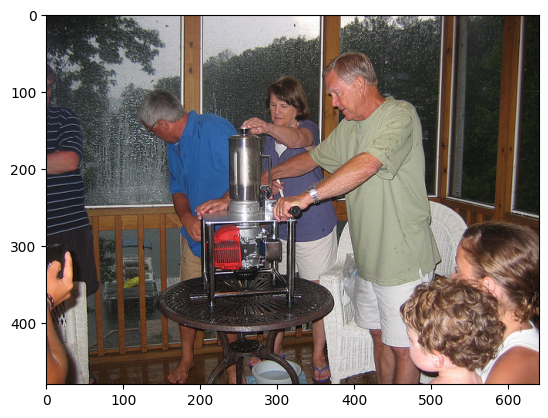

In [109]:
count = 0
for k, v in data.items():
  if count == 24:
    print(data[k])
    print(k)
    img =  Image.open(k).convert('RGB') 
    plt.imshow(img)
  count +=1

In [110]:
transform(img).size()

torch.Size([3, 224, 224])

In [112]:
dataset = Dset.from_dict({'image': data.keys(), 'caption': data.values()}).train_test_split(test_size=0.1, seed=42)

In [113]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'caption'],
        num_rows: 27000
    })
    test: Dataset({
        features: ['image', 'caption'],
        num_rows: 3000
    })
})

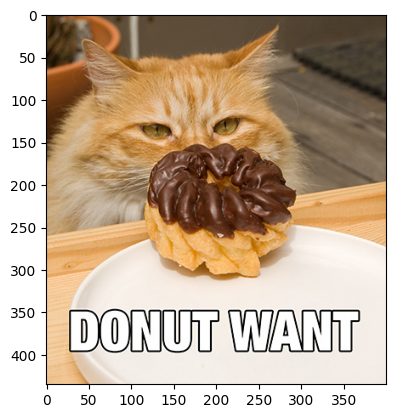

In [115]:
img = Image.open(dataset['train']['image'][41]).convert('RGB')
plt.imshow(img)

In [116]:
#Download captions
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#Extract archive 
!unzip annotations_trainval2017.zip

--2023-05-27 05:25:34--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.171.241, 52.216.108.11, 52.216.114.179, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.171.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  33.6MB/s    in 7.7s    

2023-05-27 05:25:42 (31.2 MB/s) - ‘annotations_trainval2017.zip.1’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [117]:
with open('annotations/captions_train2017.json', 'r') as f:
    array = json.load(f)

array.keys()

dict_keys(['info', 'licenses', 'images', 'annotations'])

In [118]:
for item in array['annotations']:
  if '\n' in item['caption']:
    strr = item['caption'].split(sep = '\n')
    strr = ''.join([strr[0], strr[1]])
    item['caption'] = strr
    #print(item['caption'])

for_vocab = []
for item in array['annotations']:
  for_vocab.append(item['caption'].split(sep = '.')[0].lower().replace('(@\w+.*?)',""))    

In [119]:
with open('temp.txt', 'w') as f: # encoding='utf-8')
    for text in for_vocab:
        f.write(text+ '\n')

In [120]:
# Train SentencePiece model
spm.SentencePieceTrainer.train('--input=temp.txt --model_prefix=mymodel --vocab_size=10000 --model_type=bpe')

# Load vocabulary
sp = spm.SentencePieceProcessor()
sp.load('mymodel.model')
#sp.pad_id(10000)

# Encode some phrase
encoded_phrase = sp.encode('a lot of motorcycles that are in a window')
print(encoded_phrase)

[3, 461, 22, 906, 136, 80, 23, 3, 393]


In [121]:
vocabs = [sp.id_to_piece(id) for id in range(sp.get_piece_size())]
len(vocabs)

10000

In [122]:
# Define the dataset class to load image-caption pairs
class ImageCaptionDataset(Dataset):
    def __init__(self, dataset, model, max_len = 20, transform=None):
        self.images = dataset['image']
        self.captions = dataset['caption'] 
        self.transform = transform
        self.bpe_model = model
        self.max_len = max_len

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        sp = spm.SentencePieceProcessor()
        sp.load(self.bpe_model)

        caption = self.captions[idx]
        caption = [sp.piece_to_id('<s>')] + sp.encode(caption) + [sp.piece_to_id('</s>')]

        
        # Pad or truncate the token IDs to the desired sequence length
        if len(caption) < self.max_len:
            # Pad with zeros at the end
            caption += [0] * (self.max_len - len(caption))
        elif len(caption) > self.max_len:
            # Truncate to the desired length
            caption = caption[:self.max_len]

        #return img, torch.tensor(caption, dtype=torch.long) 

        return {
        #"image_id": torch.tensor(image_id, dtype=torch.long),
        "image": img.to(device),
        "caption_tokens": torch.tensor(caption, dtype=torch.long, device = device),
        #"noitpac_tokens": torch.tensor(caption, dtype=torch.long),
        "caption_lengths": torch.tensor(len(caption), dtype=torch.long, device = device),
            }


In [123]:
bpe_model = 'mymodel.model'

train_dataloader = DataLoader(ImageCaptionDataset(dataset['train'], bpe_model, transform = transform), shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(ImageCaptionDataset(dataset['test'], bpe_model, transform = transform), shuffle=False, batch_size=batch_size)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [124]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

 
class resnet50(nn.Module):
  def __init__(self, block, image_channels = 3, num_classes = 1000):
      super(resnet50, self).__init__()
      self.expansion = 4
      layers = [3, 4, 6, 3]
      self.in_channels = 64
      self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
      self.bn1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

      # ResNetLayers
      self.layer1 = self.make_layers(block, layers[0], intermediate_channels=64, stride=1)
      self.layer2 = self.make_layers(block, layers[1], intermediate_channels=128, stride=2)
      self.layer3 = self.make_layers(block, layers[2], intermediate_channels=256, stride=2)
      self.layer4 = self.make_layers(block, layers[3], intermediate_channels=512, stride=2)

      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.Linear(512 * self.expansion, num_classes)

  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      x = self.avgpool(x)
      x = x.reshape(x.shape[0], -1)
      x = self.fc(x)
      return x

  def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
      layers = []

      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                          nn.BatchNorm2d(intermediate_channels*self.expansion))
      layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
      self.in_channels = intermediate_channels * self.expansion # 256
      for i in range(num_residual_blocks - 1):
          layers.append(block(self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
      return nn.Sequential(*layers)


# Define the Encoder network based on ResNet-50
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = resnet50(Block)
        for param in resnet.parameters():
          param.requires_grad_(True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, x):
        features = self.resnet(x)
        return features


In [125]:
def create_position_indices(tokens):

    # Create position indices of the same size as token indices
    batch_size, max_caption_length = tokens.size()
    positions = torch.arange(max_caption_length, dtype=tokens.dtype, device= device)
    # shape: (batch_size, max_caption_length)
    positions = positions.unsqueeze(0).expand(batch_size, max_caption_length)
    return positions 

In [126]:
class WordAndPositionalEmbedding(nn.Module):
      def __init__(
        self,
        vocab_size: int = 10000, 
        hidden_size: int = 256,
        dropout: float = 0.1,
        max_caption_length: int = 20,
        padding_idx: int = 0):

        super().__init__()
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.words = nn.Embedding(vocab_size, hidden_size, padding_idx=padding_idx)

        # No "padding index" for positional embeddings is provided. 
        # The positional embeddings of padded positions are zeroed out as a post-processing
        self.positions = nn.Embedding(max_caption_length, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-8, elementwise_affine=True)
        self.dropout = nn.Dropout(p=dropout)

      def forward(self, tokens: torch.Tensor) -> torch.Tensor:

          position_indices = create_position_indices(tokens)

          # shape: (batch_size, max_caption_length, hidden_size)
          word_embeddings = self.words(tokens)
          position_embeddings = self.positions(position_indices)

          # shape: (batch_size, max_caption_length, hidden_size)
          embeddings = self.layer_norm(word_embeddings + position_embeddings)
          embeddings = self.dropout(embeddings)

          # Zero-out embeddings for positions which have padding tokens
          # shape: (batch_size, max_caption_length, 1)
          token_mask = (tokens != self.padding_idx).unsqueeze(-1).to(device)

          # shape: (batch_size, max_caption_length, hidden_size)
          embeddings = embeddings * token_mask.type(embeddings.dtype)
          return embeddings

In [127]:
class TransformerDecoderTextualHead(nn.Module):
    def __init__(
        self,
        visual_feature_size: int = 2048,
        vocab_size: int = 10000,
        hidden_size: int = 256,
        num_layers: int = 6,
        attention_heads: int = 8,
        feedforward_size: int = 2048,
        dropout: float = 0.1,
        norm_first: bool = False,
        mask_future_positions: bool = True,
        max_caption_length: int = 20,
        padding_idx: int = 0,
    ):
        super().__init__()
        self.visual_feature_size = visual_feature_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention_heads = attention_heads
        self.feedforward_size = feedforward_size
        self.dropout = dropout
        self.mask_future_positions = mask_future_positions
        self.padding_idx = padding_idx

        self.visual_projection = nn.Linear(self.visual_feature_size, self.hidden_size)
        self.embedding = WordAndPositionalEmbedding(
            self.vocab_size,
            self.hidden_size,
            dropout=dropout,
            max_caption_length=max_caption_length,
            padding_idx=self.padding_idx,
        )

        self.transformer = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                self.hidden_size,
                self.attention_heads,
                dim_feedforward=self.feedforward_size,
                dropout=dropout,
                activation="gelu",
                batch_first=True,
                norm_first=norm_first,
            ),
            num_layers=self.num_layers,
            # Add final layer norm for pre-norm transformers.
            norm=nn.LayerNorm(self.hidden_size) if norm_first else None,
        )
        self.apply(self._init_weights)

        # Create an output linear layer and tie the input and output word
        # embeddings to reduce parameters
        self.output = nn.Linear(self.hidden_size, vocab_size)
        self.output.weight = self.embedding.words.weight

    @staticmethod
    def _init_weights(module):
        r"""Initialize weights like BERT - N(0.0, 0.02), bias = 0."""

        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.MultiheadAttention):
            module.in_proj_weight.data.normal_(mean=0.0, std=0.02)
            module.out_proj.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

    def forward(
        self,
        visual_features: torch.Tensor,
        caption_tokens: torch.Tensor,
        caption_lengths: torch.Tensor,
    ) -> torch.Tensor:

        # Convert to NHWC and project visual features to textual feature size
        batch_size, channels, height, width = visual_features.size()
        visual_features = visual_features.view(batch_size, channels, -1)
        visual_features = visual_features.permute(0, 2, 1)

        # shape: (batch_size, height * width, hidden_size)
        projected_visual_features = self.visual_projection(visual_features)
        batch_size, max_caption_length = caption_tokens.size()

        ones = torch.ones_like(caption_tokens, device = device)
        caption_mask = caption_lengths.unsqueeze(1) < ones.cumsum(dim=1)
        caption_mask.to(device)

        # shape: (batch_size, max_caption_length, hidden_size)
        caption_embeddings = self.embedding(caption_tokens)

        if self.mask_future_positions:
            # An additive mask for masking the future (one direction)
            future_mask = self.make_future_mask(
                max_caption_length, caption_embeddings.dtype, caption_embeddings.device) #, caption_embeddings.device)
          
        else:
            future_mask = None

        # shape: (batch_size, max_caption_length, hidden_size)
        textual_features = self.transformer(
            caption_embeddings,
            projected_visual_features,
            tgt_mask=future_mask,
            tgt_key_padding_mask=caption_mask,
        )
        # shape: (batch_size, max_caption_length, vocab_size)
        output_logits = self.output(textual_features)
        return output_logits

    @staticmethod
    @functools.cache
    def make_future_mask(
        size: int, dtype: torch.dtype, device: torch.device
    ) -> torch.Tensor:
        return torch.triu(
            torch.full((size, size), float("-inf"), dtype=dtype, device = device), #, device=device
            diagonal=1,
        )

In [128]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super().__init__()

        # Compute the positional encoding matrix
        pe = torch.zeros(max_sequence_length, d_model, device = device)
        position = torch.arange(0, max_sequence_length, dtype=torch.float, device = device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model), device = device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
      x = x + self.pe[:, :x.size(1), :]
      return x


In [129]:
class CaptioningModel(nn.Module):
  def __init__(
        self,
        visual: Encoder,
        textual: TransformerDecoderTextualHead,
        sos_index: int = 1,
        eos_index: int = 2,
        decoder: Any = None):
    
        super().__init__()

        self.visual = visual
        self.textual = textual
        self.padding_idx = self.textual.padding_idx
        # These boundary indices are needed for beam search.
        self.sos_index = sos_index
        self.eos_index = eos_index
        self.decoder = decoder
        self.loss = nn.CrossEntropyLoss(ignore_index = self.padding_idx)


  def forward(self, batch: Dict[str, torch.Tensor]) -> Dict[str, Any]:

          # shape: (batch_size, channels, height, width) 
          visual_features = self.visual(batch["image"].to(device))
          batch_size = visual_features.size(0)

          if "caption_tokens" in batch:
              caption_tokens = batch["caption_tokens"].to(device)
              caption_lengths = batch["caption_lengths"].to(device)

              # shape: (batch_size, max_caption_length, vocab_size)
              output_logits = self.textual(
                  visual_features, caption_tokens, caption_lengths
              )
              loss = self.loss(
                  output_logits[:, :-1].contiguous().view(-1, self.textual.vocab_size),
                  caption_tokens[:, 1:].contiguous().view(-1),
              )
              return loss
        

In [130]:
model = CaptioningModel(Encoder(), TransformerDecoderTextualHead()).to(device)
optimizer = optim.Adam(list(model.parameters()), lr=learning_rate)
n_epochs = 100

In [133]:
 def train(model, optimizer, dataloaders, n_epochs = 5):

  scaler = torch.cuda.amp.GradScaler()
 
  history_loss_train = []
  history_loss_val = []
  since = time.time()

  for epoch in trange(n_epochs, colour = "#008B8B"):
      print('Epoch {}/{}'.format(epoch+1, n_epochs))
      print('-' * 10)

      for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()   

        running_loss = 0.0

        for i, batch in enumerate(dataloaders[phase]):
              # forward
              with torch.set_grad_enabled(phase == 'train'):
                  optimizer.zero_grad()
                  loss = model.forward(batch)
                  #with autocast():
                    # loss = model.forward(batch)
                    # scaler.scale(loss).backward()
                    # scaler.step(optimizer)
                    # scaler.update()

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              running_loss += loss.item() * batch['image'].size(0)

        running_loss = running_loss / len(dataloaders[phase].dataset)
        
        if phase == 'train':
          history_loss_train.append(running_loss)

        if phase == 'val':
          print('{} Loss: {:.4f}\n'.format(phase, running_loss))
          history_loss_val.append(running_loss)

      if epoch % 5 == 0:
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          #'scaler_state_dict': scaler.state_dict(),
      }, '/content/drive/MyDrive/VirTex_checkpoint30000_iter.pth')


  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  torch.save(model.state_dict(), '/content/drive/MyDrive/VirTex_trained_params30000_resulting.pth')
  return history_loss_train, history_loss_val

In [134]:
list_loss_train, list_loss_val = train(model, optimizer, dataloaders, n_epochs = n_epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


val Loss: 3.5970



  1%|          | 1/100 [4:04:11<402:54:48, 14651.39s/it]

Epoch 2/100
----------


  2%|▏         | 2/100 [4:19:25<178:52:00, 6570.61s/it] 

val Loss: 3.3416

Epoch 3/100
----------


  3%|▎         | 3/100 [4:34:19<107:11:44, 3978.40s/it]

val Loss: 3.1282

Epoch 4/100
----------


  4%|▍         | 4/100 [4:49:08<73:34:05, 2758.81s/it] 

val Loss: 3.0452

Epoch 5/100
----------


  5%|▌         | 5/100 [5:04:15<55:10:43, 2090.98s/it]

val Loss: 2.9960

Epoch 6/100
----------
val Loss: 3.0045



  6%|▌         | 6/100 [5:19:21<44:04:40, 1688.09s/it]

Epoch 7/100
----------


  7%|▋         | 7/100 [5:34:23<36:58:31, 1431.30s/it]

val Loss: 2.9560

Epoch 8/100
----------


  8%|▊         | 8/100 [5:49:38<32:22:26, 1266.81s/it]

val Loss: 2.9560

Epoch 9/100
----------


  9%|▉         | 9/100 [6:04:25<29:01:21, 1148.15s/it]

val Loss: 2.9665

Epoch 10/100
----------


 10%|█         | 10/100 [6:18:58<26:34:52, 1063.25s/it]

val Loss: 2.9764

Epoch 11/100
----------
val Loss: 2.9912



 11%|█         | 11/100 [6:33:44<24:56:38, 1008.97s/it]

Epoch 12/100
----------


 12%|█▏        | 12/100 [6:48:41<23:49:48, 974.86s/it] 

val Loss: 3.0013

Epoch 13/100
----------


 13%|█▎        | 13/100 [7:03:34<22:57:29, 950.00s/it]

val Loss: 3.0200

Epoch 14/100
----------


 14%|█▍        | 14/100 [7:18:02<22:06:19, 925.35s/it]

val Loss: 3.0571

Epoch 15/100
----------


 15%|█▌        | 15/100 [7:32:10<21:17:48, 901.98s/it]

val Loss: 3.0841

Epoch 16/100
----------
val Loss: 3.1290



 16%|█▌        | 16/100 [7:46:02<20:33:05, 880.78s/it]

Epoch 17/100
----------


 17%|█▋        | 17/100 [8:00:04<20:02:39, 869.39s/it]

val Loss: 3.3589

Epoch 18/100
----------


 18%|█▊        | 18/100 [8:13:59<19:33:51, 858.92s/it]

val Loss: 3.1965

Epoch 19/100
----------


 19%|█▉        | 19/100 [8:27:54<19:09:58, 851.84s/it]

val Loss: 3.2688

Epoch 20/100
----------


 20%|██        | 20/100 [8:41:51<18:49:48, 847.35s/it]

val Loss: 3.3156

Epoch 21/100
----------


 20%|██        | 20/100 [8:53:46<35:35:07, 1601.34s/it]


FileNotFoundError: ignored

### Check how VirTex works for image captioning on CelebA dataset - compare it with pretrained ResNet50

Links to the trained Virtex and CelebA train/val/test datasets on my Google Drive

Trained Virtex (on 10K COCO images, 5 iterations):
https://drive.google.com/file/d/1-D7DLSkMWZiqJHyfMlr_oG92Vrs0T408/view?usp=sharing

Trained Virtex (on 30K COCO images, 10 iterations):
https://drive.google.com/file/d/15OFFxRw0fcpo_OUlIipq5NZyQ_GW1ouU/view?usp=sharing

Trained Virtex (on 30K COCO images, 15 iterations):
https://drive.google.com/file/d/1ztI9Sp64vGG7MTP-g2AUW3v37EZCqqj_/view?usp=sharing


Trained Virtex (on 30K COCO images, 20 iterations):
https://drive.google.com/file/d/138X39mh7tDpanA-ZHv1cw2ta6GATjp91/view?usp=sharing



Zip files with CelebA images and masks:

https://drive.google.com/file/d/1xX-Td5piFN5NhIzpEzHTekQ3Dq_ZSHX9/view?usp=sharing

https://drive.google.com/file/d/17NuksAkmkguu8OeXG_8xmcucs0Wc2oH2/view?usp=sharing

https://drive.google.com/file/d/1hX0k1_mgEMlnANY_oitFsHpIpuyFowQk/view?usp=sharing

In [227]:
# Load trained Virtex model

Virtex_trained = CaptioningModel(Encoder(), TransformerDecoderTextualHead()).to(device)
Virtex_trained_path = "/content/drive/MyDrive/VirTex_checkpoint30000_20iter.pth" 
Virtex_trained.load_state_dict(torch.load(Virtex_trained_path)['model_state_dict'])

<All keys matched successfully>

In [228]:
# Encoder (visual) part of Virtex - the target model, to compare in further with pretrained ResNet50
Virtex_encoder = Virtex_trained.visual
Virtex_encoder

Encoder(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Block(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (identity_downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(25

In [229]:
import torchvision
resnet1 = torchvision.models.resnet50(pretrained = True)
resnet1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [230]:
# Prepare Virtex_encoder for segmentation tasks

# Define segmentation head
segmentation_head = nn.Sequential(
    nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 19, kernel_size=2, stride=2, padding=0)
)

# Combine trained Virtex and segmentation head
model = nn.Sequential(Virtex_encoder, segmentation_head).to(device)

# Test with a dummy input
x = torch.randn(1, 3, 512,  512)
output = model(x.to(device))
print(output.shape) # should print (1, 19, 512, 512)

torch.Size([1, 19, 512, 512])


In [231]:
_ = model.eval()

Downloading and working with CelebA dataset

In [232]:
transform_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [233]:
label_list = {'0': 'background', 1: 'skin', 2: 'nose', 3: 'eye_g', 4: 'l_eye',
                  '5': 'r_eye', '6': 'l_brow', 7: 'r_brow', 8: 'l_ear', 9: 'r_ear',
                  '10': 'mouth',	11: 'u_lip', 12: 'l_lip',	13: 'hair',
                  '14': 'hat', 15: 'ear_r',	16: 'neck_l',	17: 'neck', 18: 'cloth'}


label_dict = {v: k for k, v in label_list.items()}
n_classes = len(label_dict)
n_classes

19

In [147]:
!unzip  /content/drive/MyDrive/img_test.zip 

Archive:  /content/drive/MyDrive/img_test.zip
replace img_test/7858.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [51]:
!unzip  /content/drive/MyDrive/CelebAMask-HQ-mask-test.zip 

Archive:  /content/drive/MyDrive/CelebAMask-HQ-mask-test.zip
   creating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/20192.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/7681.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/27015.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/12295.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/8029.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/16009.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/8564.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/25558.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/1977.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/12735.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/2498.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-test/27165.png  
  inflating: content/CelebAMask-

In [52]:
!unzip  /content/drive/MyDrive/CelebAMask-HQ-mask-color-test.zip 

Archive:  /content/drive/MyDrive/CelebAMask-HQ-mask-color-test.zip
   creating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/20192.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/7681.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/27015.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/12295.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/8029.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/16009.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/8564.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/25558.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/1977.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/12735.png  
  inflating: content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test/2498.png  
  inflating: content/Cele

In [234]:
# Train/test/val split file for CelebA

url = 'https://drive.google.com/uc?id=1t6lZKx70FO6OpnRKdGK3gZLmnZM7zrP6'

celeb_train_test_split = pd.read_csv(url)

celeb_train_test_split.head()

,name,is_train
0,28929.jpg,True
1,1741.jpg,True
2,11349.jpg,True
3,14782.jpg,True
4,2129.jpg,True


In [235]:
df_test_ind = pd.DataFrame()
df_test_ind['id'] = celeb_train_test_split[celeb_train_test_split['is_train'] != True]['name']

In [236]:
df_test_ind = df_test_ind.reset_index(drop = True)
df_test_ind['id'] = df_test_ind['id'].str.replace('.jpg', '')
df_test_ind['id'] = df_test_ind['id'].astype('int32')

<ipython-input-236-b51bcece6d3d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test_ind['id'] = df_test_ind['id'].str.replace('.jpg', '')


In [237]:
df_test_ind.head()

,id
0,7535
1,9650
2,3427
3,15304
4,22581


In [238]:
root_path = '/content/drive/MyDrive/'
masks_test_path = 'content/CelebAMask-HQ/CelebAMask-HQ-mask-test'
masks_color_test_path = 'content/CelebAMask-HQ/CelebAMask-HQ-mask-color-test'
imgs_test_path = '/content/drive/MyDrive/img_test'

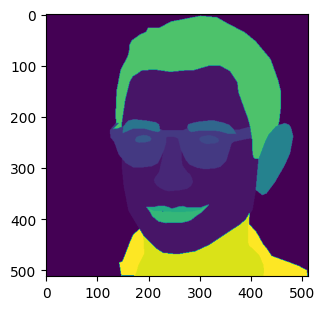

In [239]:
mask = Image.open(os.path.join(root_path, masks_test_path, str(15304) + '.png'))
plt.figure(figsize = (3.4, 3.4))
plt.imshow(mask, aspect = 1)

In [240]:
def clean_df(df, root_path, imgs_path, masks_path):
  empty_ids = []

  for id in df['id']:
    img_filename = os.path.join(root_path, imgs_path, str(id) + '.jpg')
    mask_filename = os.path.join(root_path, masks_path, str(id) + '.png')
    
    if not os.path.exists(img_filename):
      #print('No mask for id', id)
      empty_ids.append(id)
      df = df[df['id'] != id] 

    if not os.path.exists(mask_filename):
      #print('No image for id', id)
      empty_ids.append(id)
      df = df[df['id'] != id] 

  return df, empty_ids

In [241]:
df_test_ind, empty_test_ids = clean_df(df_test_ind, root_path, imgs_test_path, masks_test_path)

len(df_test_ind)

1250

In [242]:
class Dataset_CelebA():
    def __init__(self, df, transform, root_path, masks_path, imgs_path, augmentation=None):
        self.transform = transform
        self.df = df
        self.root_path = root_path
        self.masks_path = masks_path
        self.imgs_path = imgs_path
        self.augmentation = augmentation


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        id = self.df[idx] 

        img_filename = os.path.join(self.root_path, self.imgs_path, str(id) + '.jpg')
        #print('img filename: ', img_filename)
        mask_filename = os.path.join(self.root_path, self.masks_path, str(id) + '.png')
        #print('mask filename: ', mask_filename)

        image = self.transform(Image.open(img_filename))
        mask = np.array(Image.open(mask_filename), dtype=np.int64)

        return image, mask


In [243]:
def test(model, dataloader, criterion=nn.CrossEntropyLoss(), device=device):

    inputs_list = []
    preds_list = []
    labels_list = []
    print('Testing mode: ')

    model.eval()
    for inputs, labels in tqdm(dataloader, colour = "#008B8B"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)


        inputs_list.extend(inputs)
        labels_list.extend(labels)
        preds_list.extend(preds)
 

    return preds_list, inputs_list, labels_list

In [244]:
batch_size1 = 4

In [245]:
generator1 = np.random.seed(42)

test_dataset = Dataset_CelebA(list(df_test_ind['id']), 
                              transform_1, root_path, masks_test_path, imgs_test_path) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator = generator1)

In [246]:
preds, inputs, labels = test(model, test_dataloader, criterion=nn.CrossEntropyLoss(), device=device)

Testing mode: 


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 157/157 [00:33<00:00,  4.69it/s]


In [247]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

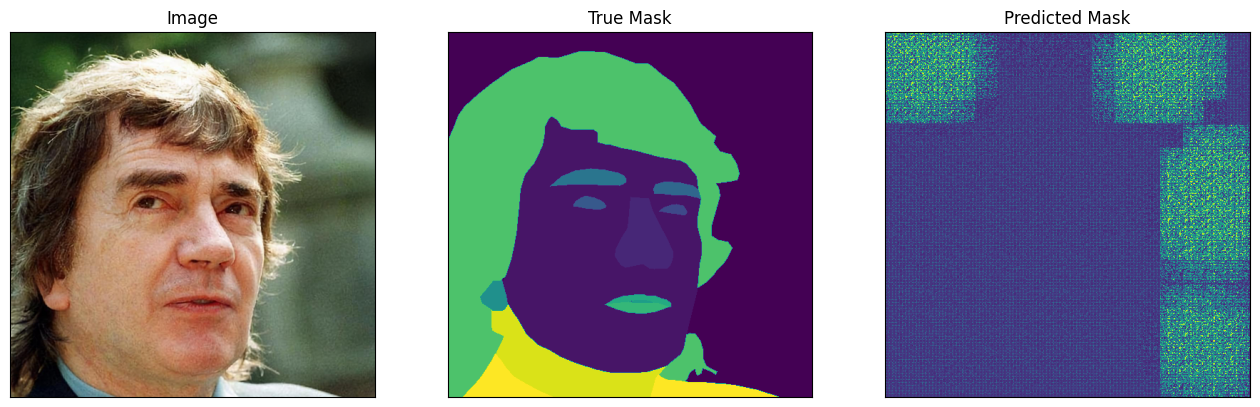

In [248]:
pred1 = preds[1].cpu().detach().numpy()

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
img1 = inv_normalize(inputs[1])
img1 = transforms.ToPILImage()(img1)

label1 = labels[1].cpu().detach().numpy()


pred_1 = Image.fromarray((pred1).astype(np.uint8))
label_1 = Image.fromarray((label1).astype(np.uint8))


visualize(
    image=img1, 
    true_mask=label_1,
    predicted_mask = pred_1
)

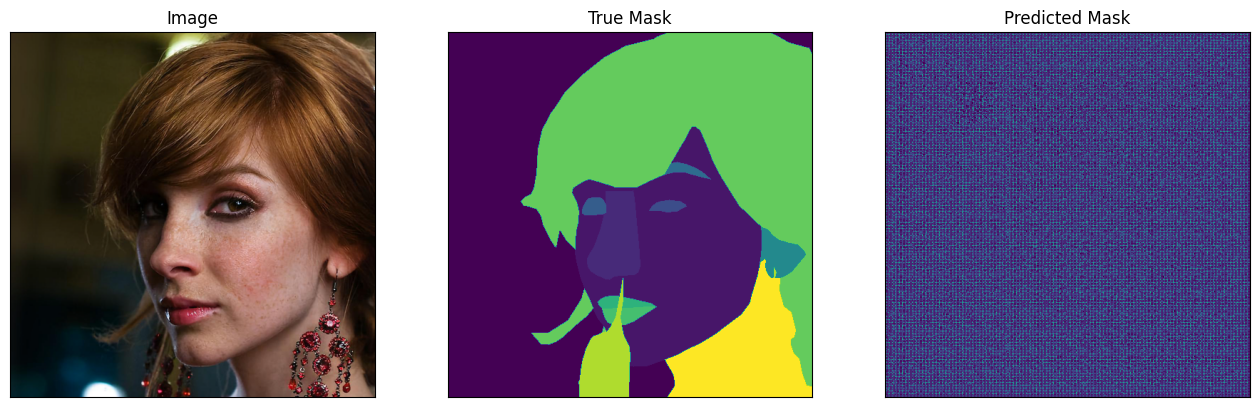

In [249]:
pred115 = preds[115].cpu().detach().numpy()

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
img115 = inv_normalize(inputs[115])
img115 = transforms.ToPILImage()(img115)

label115 = labels[115].cpu().detach().numpy()


pred_115 = Image.fromarray((pred115).astype(np.uint8))
label_115 = Image.fromarray((label115).astype(np.uint8))


visualize(
    image=img115, 
    true_mask=label_115,
    predicted_mask = pred_115)

In [250]:
# Compute Dice metric for the test dataset
from torchmetrics import Dice

dice = Dice(num_classes = 19, average='micro').to(device)
summ = 0
for x, y in zip(preds, labels):
  summ += dice(x.to(device), y.to(device))

dice_average = summ/len(labels)

dice_average

tensor(0.0133, device='cuda:0')

Dice for Virtex trained on 30000 images: 
- for 20 iterations: 0.0133 
- for 15 iterations: 0.2452 
- for 10 iterations: 0.0073


#### The results for Virtex trained: 
#### a) on 10000 images for 5 iterations; 
#### b) on 30000 images trained for 10; 15; 20 iterations
#### are bad, especially compared to ResNet50 pretrained on 14 mln images of ImageNet dataset. 

#### I guess Virtex needs more training and ideally on the full COCO dataset. At least, the authors in the paper used full COCO (118K images) and trained for some 500K iterations.

In [225]:
preds[0].size()

torch.Size([512, 512])